# Deep Learning

# Keras image classification 

[Repositori Original](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=kDdSgKf1r9oY)
Utilitzarem la base de dades MNIST, que ens proporciona un Data Set de números escrits a mà

In [17]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils  # NumPy related tools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [16]:
def show_plots(history, metric=None, plot_title=None, fig_size=None):

    import seaborn as sns

    """ Useful function to view plot of loss values & 'metric' across the various epochs
        Works with the history object returned by the fit() or fit_generator() call """
    assert type(history) is dict

    # we must have at least loss in the history object
    assert 'loss' in history.keys(), f"ERROR: expecting \'loss\' as one of the metrics in history object"
    if metric is not None:
        assert isinstance(metric, str), "ERROR: expecting a string value for the \'metric\' parameter"
        assert metric in history.keys(), f"{metric} is not tracked in training history!"

    loss_metrics = ['loss']
    if 'val_loss' in history.keys():
        loss_metrics.append('val_loss')
    # after above lines, loss_metrics = ['loss', 'val_loss']

    other_metrics = []
    if metric is not None:
        other_metrics.append(metric)
        if f"val_{metric}" in history.keys():
            other_metrics.append(f"val_{metric}")
    # if metric is not None (e.g. if metrics = 'accuracy'), then other_metrics = ['accuracy', 'val_accuracy']

    # display the plots
    col_count = 1 if len(other_metrics) == 0 else 2
    df = pd.DataFrame(history)

    with sns.axes_style("darkgrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(nrows=1, ncols=col_count, figsize=((16, 5) if fig_size is None else fig_size))
        axs = ax[0] if col_count == 2 else ax

        # plot the losses
        losses_df = df.loc[:, loss_metrics]
        losses_df.plot(ax=axs)
        #ax[0].set_ylim(0.0, 1.0)
        axs.grid(True)
        losses_title = 'Training \'loss\' vs Epochs' if len(
            loss_metrics) == 1 else 'Training & Validation \'loss\' vs Epochs'
        axs.title.set_text(losses_title)

        # plot the metric, if specified
        if metric is not None:
            metrics_df = df.loc[:, other_metrics]
            metrics_df.plot(ax=ax[1])
            ax[1].set_ylim(0.0, 1.0)
            ax[1].grid(True)
            metrics_title = f'Training \'{other_metrics[0]}\' vs Epochs' if len(other_metrics) == 1 \
                else f'Training & Validation \'{other_metrics[0]}\' vs Epochs'
            ax[1].title.set_text(metrics_title)

        if plot_title is not None:
            plt.suptitle(plot_title)

        plt.show()
        plt.close()


> Cargarem la base de dades MNIST i la normalitzarem de 0 a 1, ja que els seus valors actuals són entre 0 i 255

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


> - Visualitzem la base de dades 
> - Aquestes es troben entre els valors 0 i 255

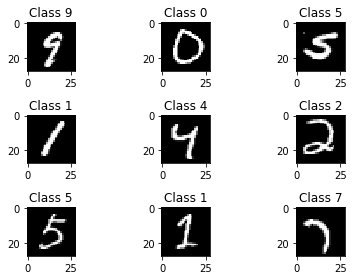

In [3]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

## Modificant la imput layer

Ens interessa crear un unic vector per l'entrada d'aquesta xarxa, per tant haurem de passar d'una imatge de dos dimensions a una. A mésn normalitzarem les imatges per tenir-les al rang [0,1]

In [4]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


## Modificant el target

El que volem és aplicar one-hot al target per tenir per cada classe un node, que ens indicarà entre el valor 0 i l'1 la probabilitat d'aquella classe:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
El més probeble és que sigui 1

In [5]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Construint la xarxa

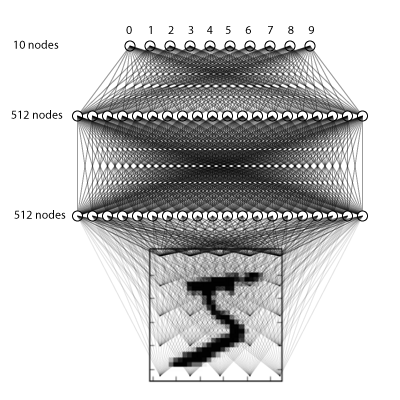

> 1. La primera hidden layer , amb una entrada de 784 nodes (28x28), cada node rebrà la info d'un pixel
> 2. Afagirem una funció d'activació RELU, aquesta asegura que el valor sigui positiu
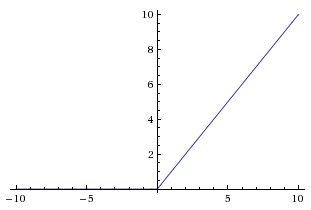
> 3. Posarem un dropout, que basixament desactiva alguns nodes per evitar l'overfitting, molt comú en imatge

In [6]:
model = Sequential()

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!
model.add(Activation('relu'))
model.add(Dropout(0.2))

2022-07-19 21:05:01.493900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 21:05:01.493922: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 21:05:01.493940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aina): /proc/driver/nvidia/version does not exist
2022-07-19 21:05:01.494158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


> La segona capa serà igual que la primera

In [7]:
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

> A la ultima layer, modificarem la funció d'activació per una sofmax, el que fa es repartir la possibilitat d'activació entre tota la layer

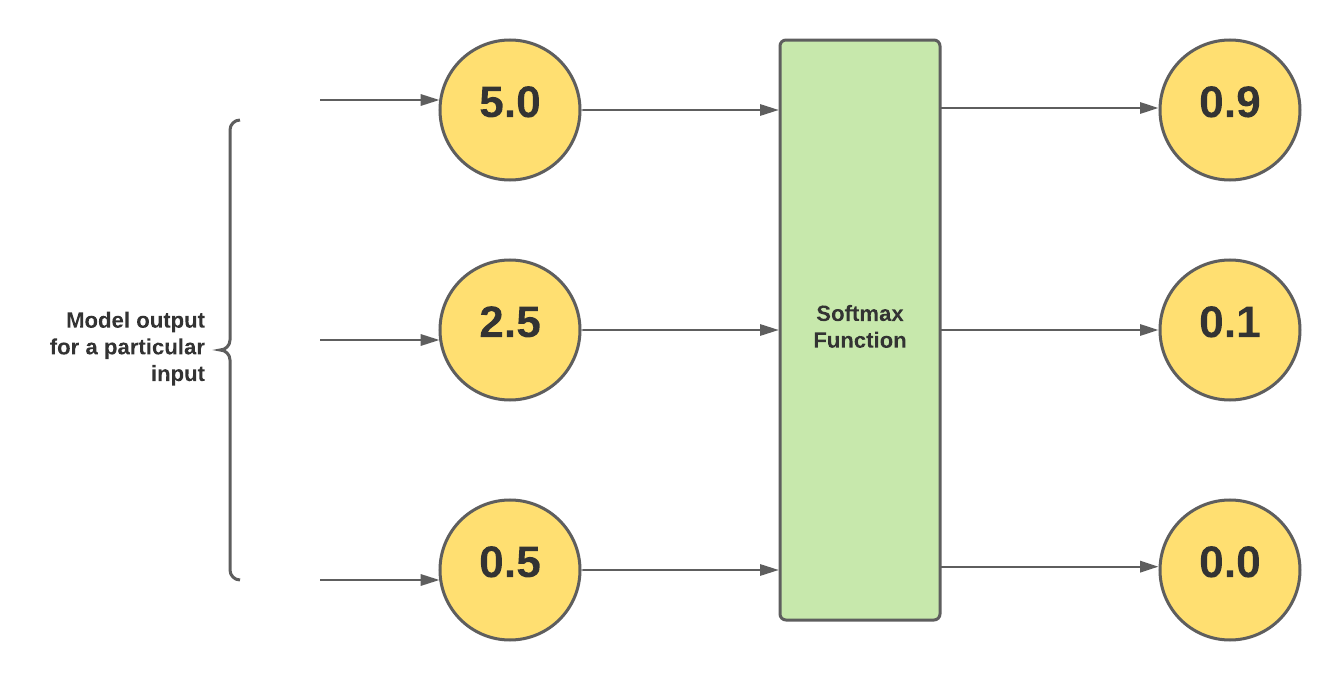

In [8]:
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

# Compilant el model


Keras is built on top of Theano and TensorFlow. Both packages allow you to define a computation graph in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical cross-entropy, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. More detail at Wikipedia

The optimizer helps determine how quickly the model learns through gradient descent. The rate at which descends a gradient is called the learning rate.

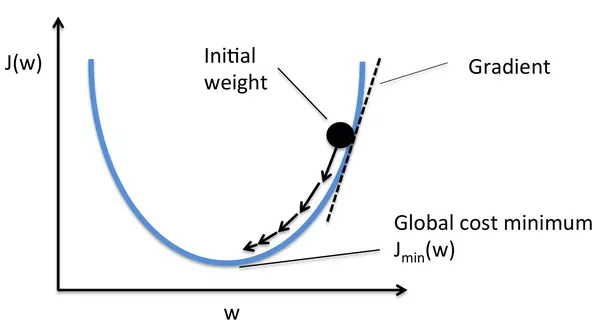

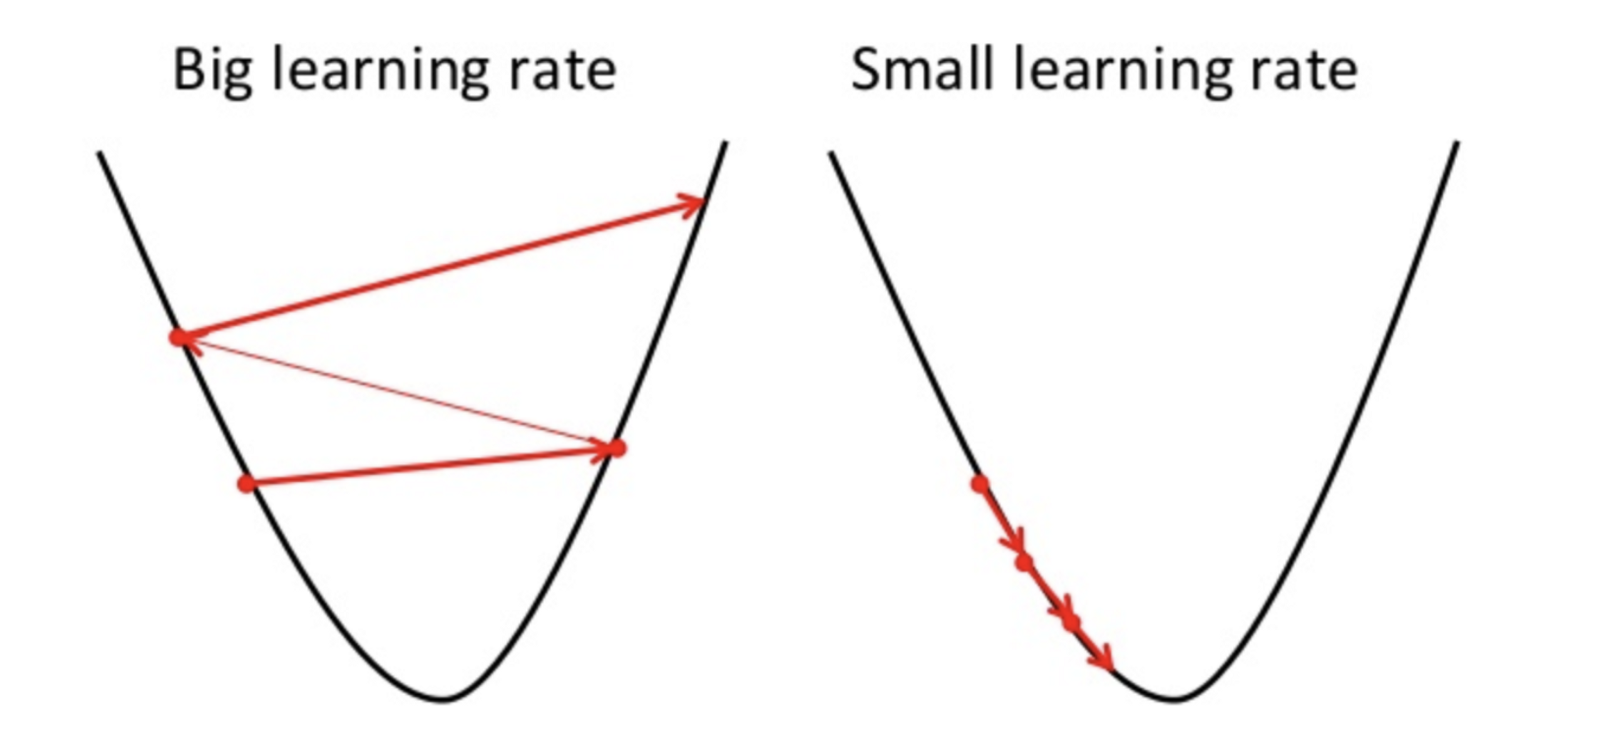

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

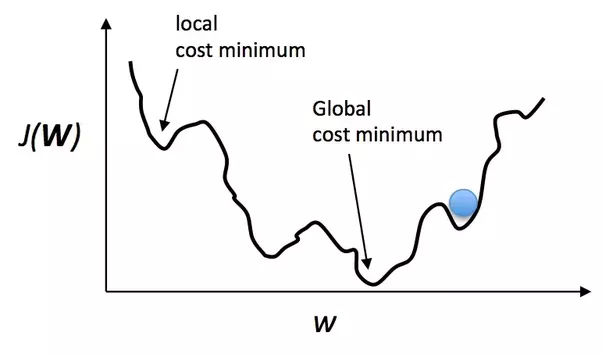

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el model


>The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

>Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

>Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

>So a good batch size may take some trial and error to find!

Crearem un set de validació de les dades, per veure si hi ha overfitting

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

results = model.fit(X_train, Y_train,
          batch_size=64, epochs=10,
          verbose=1, validation_data=(X_val,Y_val))

Epoch 1/10
354/354 [==============================] - 3s 7ms/step - loss: 0.0307 - accuracy: 0.9947 - val_loss: 0.0109 - val_accuracy: 0.9979
Epoch 2/10
354/354 [==============================] - 3s 8ms/step - loss: 0.0100 - accuracy: 0.9979 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 3/10
354/354 [==============================] - 3s 7ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0055 - val_accuracy: 0.9985
Epoch 4/10
354/354 [==============================] - 3s 7ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 5/10
354/354 [==============================] - 3s 8ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0037 - val_accuracy: 0.9985
Epoch 6/10
354/354 [==============================] - 3s 7ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 7/10
354/354 [==============================] - 3s 7ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0054 - val_accuracy: 0.9989
Epoch 

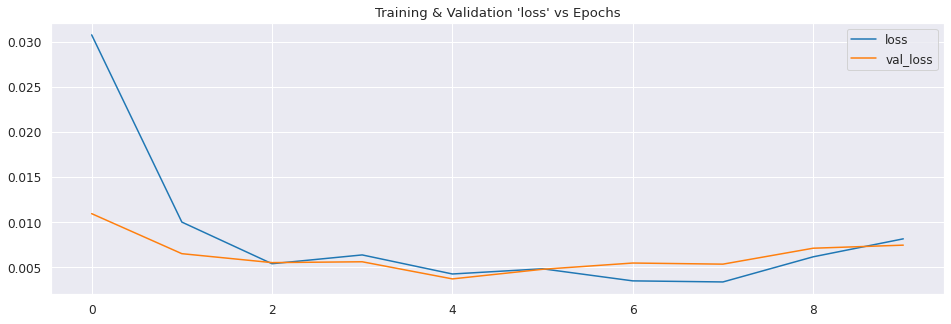

In [33]:
show_plots(results.history)

In [34]:
test_loss, test_accuracy = \
  model.evaluate(X_test, Y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

157/157 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9838
Test loss: 0.1887 accuracy: 0.9838


# Prediccions

Ara que ja hem entrenat el model,anem a veure que tal la predicció!

In [35]:
predictions = model.predict(X_test)
first20_preds = np.argmax(predictions, axis=1)[:25]
first20_true = np.argmax(Y_test,axis=1)[:25]
print(first20_preds)
print(first20_true)

313/313 [==============================] - 1s 1ms/step
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4]


[Text(0.5, 1.0, 'Confusion matrix')]

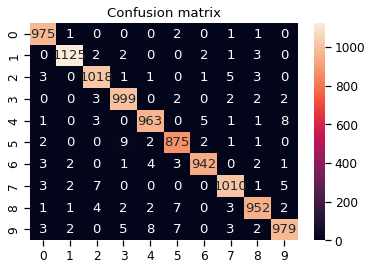

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(cf_matrix, annot=True, fmt="d").set(title='Confusion matrix')